## Table of contents:
* [Loading data](#loading-data)
* [Compute calibration](#compute-calibration)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import scipy.integrate as integrate
import scipy.stats as stats
import scipy.optimize as optimize
import tqdm

import sys
sys.path.append('../core')
sys.path.append('..')

from core import erm, gamp
from overlaps import Overlaps, average_overlaps
import core.calibration
import utility
import joint_density
import display as display_

import gcmpyo3

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=10)    # legend fontsize
plt.rc('ytick', labelsize=10)    # legend fontsize
plt.rc('legend', fontsize=10)    # legend fontsize

### Below are the functions to compute the optimal $\lambda_{\rm error}$ and $\lambda_{\rm loss}$

In [3]:
def generalisation_loss_probit_teacher(teacher_square_norm, m, q, noise_variance):
    """
        It's still going to be with a logistic student
    """
    bound = 10.0
    teacher    = gcmpyo3.Probit(noise_variance = 0.0)
    student_Z0 = lambda y, omega : np.log(1 + np.exp(- y * omega))
    
    loss  = 0.0

    for y in [-1.0, 1.0]:
        tmp = integrate.quad(lambda xi : teacher.call_z0(y, m / np.sqrt(q) * xi, teacher_square_norm - m**2 / q + noise_variance) * student_Z0(y, np.sqrt(q) * xi) * stats.norm.pdf(xi, loc = 0.0, scale = 1.0), 
                               -bound, bound)
        loss  += tmp[0]

    return loss

def generalisation_error_probit_teacher(teacher_square_norm, m, q, noise_variance):
    return 1. / np.pi * np.arccos(m / (np.sqrt(q * (teacher_square_norm + noise_variance))))

In [4]:
def find_lambda_loss(sampling_ratio, noise_variance, teacher_square_norm = 1.0, lambda_min = 1e-4, lambda_max = 1.0, tolerance = 1e-4):
    def to_optimize(lambda_):
        # tolerance for converrgence criterion in state evolution equations
        m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_matching(sampling_ratio, noise_variance, lambda_, teacher_square_norm, "probit" , tolerance, True, False)
        return generalisation_loss_probit_teacher(teacher_square_norm, m, q, noise_variance)
    result = optimize.minimize_scalar(to_optimize, bounds = (lambda_min, lambda_max), method = 'bounded')
    return result.x

def find_lambda_error(sampling_ratio, noise_variance, teacher_square_norm = 1.0, lambda_min = 1e-4, lambda_max = 1.0, tolerance = 1e-4):
    def to_optimize(lambda_):
        # tolerance for converrgence criterion in state evolution equations
        m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_matching(sampling_ratio, noise_variance, lambda_, teacher_square_norm, "probit" , tolerance, True, False)
        return generalisation_error_probit_teacher(teacher_square_norm, m, q, noise_variance)
    result = optimize.minimize_scalar(to_optimize, bounds = (lambda_min, lambda_max), method = 'bounded')
    return result.x

In [10]:
sigma = 0.5
alphas = np.linspace(0.5, 15, 20)   


### Plot for $\tau = 0.5$ <a class="anchor" id="loading-data"></a>

In [ ]:

lambdas_loss = [ find_lambda_loss(alpha, sigma**2, 1.0, tolerance = 1e-3) for alpha in tqdm.tqdm(alphas) ]
lambdas_error= [ find_lambda_error(alpha, sigma**2, 1.0, tolerance = 1e-3) for alpha in tqdm.tqdm(alphas) ]

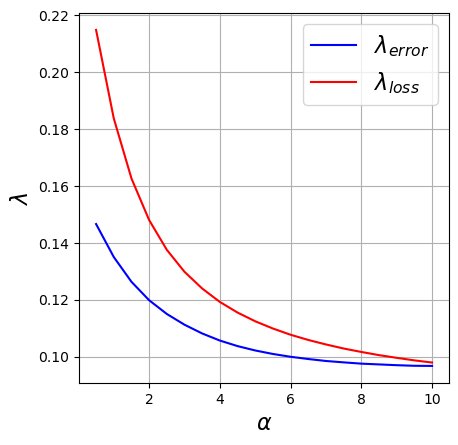

In [103]:
fig = plt.figure()
ax = fig.add_subplot()

plt.plot(alphas, lambdas_error, 'b', label='$\\lambda_{error}$')
try:
    plt.plot(alphas, lambdas_loss, 'r', label='$\\lambda_{loss}$')
except Exception as e:
    print(e)
    
ax.set_aspect(1./ax.get_data_ratio())

# plt.title(f'Optimal $\\lambda$ $\\sigma$ = {sigma}')

plt.xlabel('$\\alpha$', fontsize=16)
plt.ylabel('$\\lambda$', fontsize=16)
plt.grid()



plt.legend(fontsize=16)
plt.show()

### Compute overlaps

In [7]:
class Overlap:
    def __init__(self, m, q, v, mhat, qhat, vhat) -> None:
        self.m = m
        self.q = q
        self.v = v
        self.mhat = mhat
        self.qhat = qhat
        self.vhat = vhat

In [6]:
def compute_overlaps(alphas, lambdas, sigma):
    overlaps = []

    for (a, l) in zip(alphas, lambdas):
        overlaps.append(Overlap(*gcmpyo3.state_evolution.erm_state_evolution_matching(a, sigma**2, l, 1.0, "probit", 1e-4, True, False)))
    return overlaps

### Compute calibration <a class="anchor" id="compute-calibration"></a>

In [124]:
p = 0.6
delta_p = 0.05

In [125]:
overlaps_lambda_error = compute_overlaps(alphas, lambdas_error, sigma)
overlaps_lambda_loss = compute_overlaps(alphas, lambdas_loss, sigma)
overlaps_bayes_optimal = [ Overlap(*gcmpyo3.state_evolution.bayes_optimal_state_evolution_matching(a, sigma**2, 1.0, "probit", 1e-4, True, False)) for a in alphas ]

calibration_lambda_error = [ core.calibration.compute_teacher_calibration(p, 1.0, o.q, o.m, sigma) for o in overlaps_lambda_error]
calibration_lambda_loss  = [ core.calibration.compute_teacher_calibration(p, 1.0, o.q, o.m, sigma) for o in overlaps_lambda_loss]

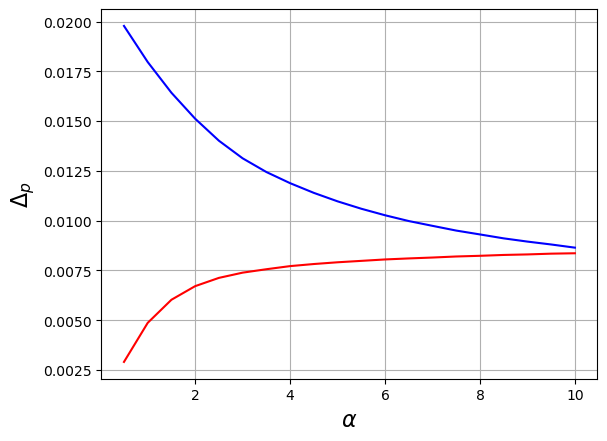

In [130]:
plt.plot(alphas, calibration_lambda_error, 'b', label='$\\lambda_{error}$')
plt.plot(alphas, calibration_lambda_loss, 'r', label='$\\lambda_{loss}$')

plt.xlabel('$\\alpha$', fontsize=16)
plt.ylabel('$\\Delta_p$', fontsize=16)

plt.grid()

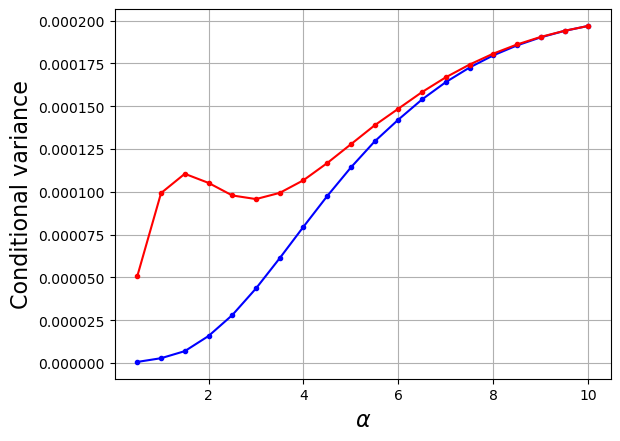

In [127]:
# Plot the conditional variance 

cond_var_error = [ gcmpyo3.utility.conditional_variance_probit(o.m, o.q, sigma**2 + 1.0 - obo.q, obo.q, utility.sigmoid_inv(p)) for o, obo in zip(overlaps_lambda_error, overlaps_bayes_optimal)]
cond_var_loss  = [ gcmpyo3.utility.conditional_variance_probit(o.m, o.q, sigma**2 + 1.0 - obo.q, obo.q, utility.sigmoid_inv(p)) for o, obo in zip(overlaps_lambda_loss, overlaps_bayes_optimal)]

plt.plot(alphas, cond_var_error, 'b', label='$\\lambda_{error}$', marker='.')
plt.plot(alphas, cond_var_loss, 'r', label='$\\lambda_{loss}$', marker='.')

plt.xlabel('$\\alpha$', fontsize=16)
plt.ylabel('Conditional variance', fontsize=16)
plt.grid()

100%|██████████| 10000/10000 [00:00<00:00, 24240.31it/s]


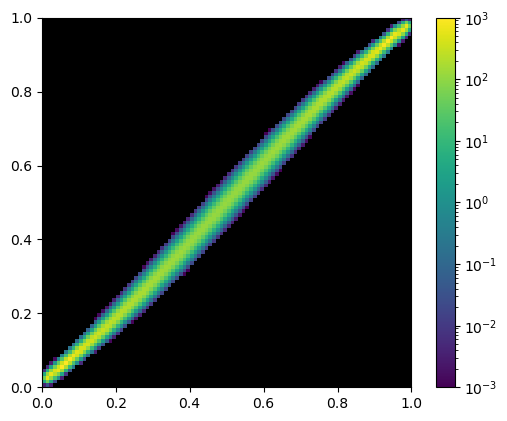

In [120]:
# plot the density of the confidences between the bayes optimal and ERM

alpha = 10.0
bo_overlap = Overlap(*gcmpyo3.state_evolution.bayes_optimal_state_evolution_matching(alpha, sigma**2, 1.0, "probit", 1e-4, True, False))
lambda_loss = find_lambda_loss(alpha, sigma**2, 1.0, tolerance = 1e-3)
loss_overlap = Overlap(*gcmpyo3.state_evolution.erm_state_evolution_matching(alpha, sigma**2, lambda_loss, 1.0, "probit", 1e-4, True, False))

Sigma_bo = np.array([[bo_overlap.q, loss_overlap.m], [loss_overlap.m, loss_overlap.q]])

N = 100
density_bo = joint_density.get_p_one_density(Sigma_bo, bo_overlap.q, N, sigma)
display_.plot_from_density(density_bo, colorbar=True, mask_vmin=1e-3, mask_vmax=1e3, sigma=sigma)

---

Reproduction of Figure 4.b) of the paper

In [21]:
p = 0.75
delta_p = 0.025
sigma_0 = 2.0
lambda_ = 1e-32

overlaps_lambda_0 = compute_overlaps(alphas, lambda_ * np.ones(len(alphas)), sigma_0)
overlaps_bo_lambda_0      = [Overlap(*gcmpyo3.state_evolution.bayes_optimal_state_evolution_matching(a, sigma_0**2, 1.0, "probit", lambda_, True, False)) for a in alphas]

Reached MAX_ITER_ERM in state evolution : last difference was 0.16972508830894495 / 0.0001, relative tol. is true
Reached MAX_ITER_ERM in state evolution : last difference was 0.0000000000000006505812492327684 / 0.00000000000000000000000000000001, relative tol. is true


In [25]:
ntrials = 10
ntest = int(10**7)
d = 300

wstar = np.random.normal(0, 1.0, d)
wstar = wstar * np.sqrt(d) / np.linalg.norm(wstar)
xtest = np.random.normal(0, 1.0, (ntest, d)) / np.sqrt(d)
ftest = utility.probit(xtest @ wstar, sigma_0)

exp_alphas = np.linspace(0.5, 15, 30)

teacher_variance = []
bo_variance = []

for alpha in tqdm.tqdm(exp_alphas):
    n = int(alpha * d)
    variance_list = []
    bo_variance_list = []
    for trial in range(ntrials):
        xtrain = np.random.normal(0, 1.0, (n, d)) / np.sqrt(d)
        ytrain = np.sign(xtrain @ wstar + sigma_0 * np.random.normal(0, 1.0, n))
        
        what = erm.erm_logistic_regression(xtrain, ytrain, lambda_)
        fhat = utility.sigmoid(xtest @ what)
        index_p = np.where((fhat > p - delta_p) & (fhat < p + delta_p))[0]
        fteacher = ftest[index_p]
        variance_list.append(np.var(fteacher))

        res_gamp = gamp.iterate_gamp(xtrain, ytrain, wstar, sig = sigma_0, verbose=False)
        wbo, vbo = res_gamp["estimator"], res_gamp["variances"]
        fbo = utility.probit(xtest @ wbo, np.sqrt(sigma_0**2 + np.mean(vbo)))
        fbo = fbo[index_p]
        bo_variance_list.append(np.var(fbo))

    teacher_variance.append(np.mean(variance_list))
    bo_variance.append(np.mean(bo_variance_list))

  0%|          | 0/30 [00:33<?, ?it/s]


KeyboardInterrupt: 

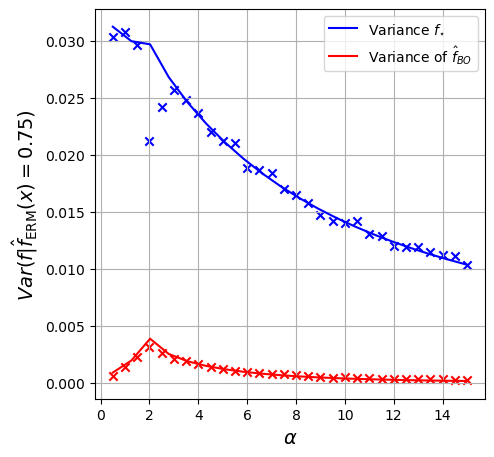

In [ ]:
# plot the variance of the the teacher for lambda_error and lambda_loss

variance_teacher = [ gcmpyo3.utility.conditional_variance_probit(o.m, o.q, sigma_0**2, 1.0, utility.sigmoid_inv(p)) for o in overlaps_lambda_0]
variance_bo = [ gcmpyo3.utility.conditional_variance_probit(o.m, o.q, sigma_0**2 + 1.0 - obo.q, obo.q, utility.sigmoid_inv(p)) for o, obo in zip(overlaps_lambda_0, overlaps_bo_lambda_0)]

plt.plot(alphas, variance_teacher, label='Variance $f_{\star}$', c='b')
plt.scatter(exp_alphas, teacher_variance, c='b', marker='x')
plt.plot(alphas, variance_bo, label='Variance of $\hat{f}_{BO}$', c='r')
plt.scatter(exp_alphas, bo_variance, c='r', marker='x')

plt.grid()
ax = plt.gca()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.xlabel('$\\alpha$')
plt.ylabel('$Var(f | \hat{f}_{\\rm ERM}(x) = 0.75)$')
plt.legend()

# do a square plot
plt.tight_layout()
plt.savefig('conditional_variance.pdf')